In [ ]:
import numpy as np
import pandas as pd
import random
import mir_utils as miru
import sounddevice as sd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from ast import literal_eval
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
#copy of openset CNN at bottom
def fitSVM(encoding_path,dvn=False):
    
    if dvn:
        label_groups="label" #do drum vs not drum
    else:
        label_groups="drum_type" #do drum vs drum vs notdrum
        
    testFraction=0.2
    #load same data as t-SNE but train SVM with it    

    df=pd.read_csv(encoding_path)
    df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


    #preperocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[label_groups])
    le.transform(df[label_groups])
    df[label_groups]=le.transform(df[label_groups])
    y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


    #calculating weights
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    y=df[label_groups]

    df["feats"]=df["feats"].apply(literal_eval)
    #df[feats] is an array of lists, needs conversion to ndArray
    X=np.array([np.array(x) for x in df["feats"].to_numpy()])
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    classifier = make_pipeline(StandardScaler(), SVC(gamma='auto',class_weight=class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(clf, X, y, cv=cv))
    classifier.fit(X_train, y_train,)
    y_pred = classifier.predict(X_test)


    return classifier, X_train, X_test, y_train, y_test,y_pred,le,X,y

p1="csvs/radarfree_best_emb.csv"
p2="csvs/radarfree_best_embenv.csv"
classifier, X_train, X_test, y_train, y_test,y_pred,le1,X,y,  = fitSVM(p1)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le1.inverse_transform(y_test),le1.inverse_transform(y_pred)))

classifier, X_train, X_test, y_train, y_test,y_pred,le2,X,y,  = fitSVM(p2)
print(confusion_matrix(y_test,y_pred))
print(classification_report(le2.inverse_transform(y_test),le2.inverse_transform(y_pred)))

In [ ]:
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix

visualizer = ClassificationReport(classifier,classes=le.classes_, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(classifier, classes=le.classes_)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.

cm.score(X_test, y_test)

# How did we do?
cm.show()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

models = [
    SVC(gamma=0.001,C= 100,kernel='rbf',class_weight=class_weights), LinearSVC(C=10,class_weight=class_weights), 
    KNeighborsClassifier(n_neighbors=30,),
    RandomForestClassifier(n_estimators=300,class_weight=class_weights), ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights),
  
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
#         ('one_hot_encoder', OneHotEncoder()),
#         ('class_weight',class_weights),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs)
    expected  = y_test
    predicted = model.predict(X_test)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average="weighted")))

for model in models:
    score_model(X, y, model,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(model, X, y, cv=cv))

In [171]:
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{
                     'n_estimators': [1100,1300,800,400,300]},
                    ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
         ExtraTreesClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train,)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 1100}

Grid scores on development set:

0.862 (+/-0.023) for {'n_estimators': 1100}
0.862 (+/-0.021) for {'n_estimators': 1300}
0.859 (+/-0.018) for {'n_estimators': 800}
0.862 (+/-0.019) for {'n_estimators': 400}
0.860 (+/-0.025) for {'n_estimators': 300}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       209
           1       0.89      0.92      0.91       635
           2       0.91      0.93      0.92       664
           3       0.80      0.78      0.79       512
           4       0.98      0.98      0.98      1003

    accuracy                           0.91      3023
   macro avg       0.88      0.87      0.87      3023
weighted avg       0.91      0.91      0.91      3023


# Tuning hy

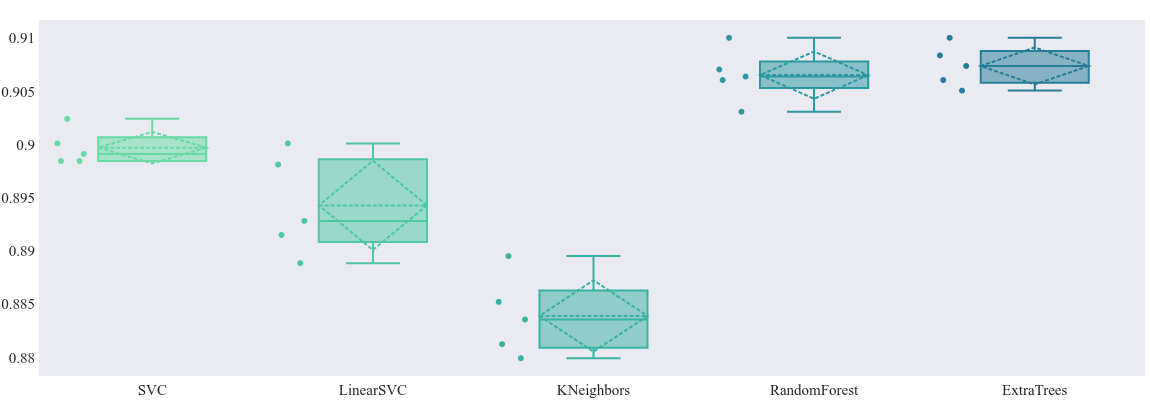

In [206]:
import plotly.graph_objects as go
import plotly
from kaleido.scopes.plotly import PlotlyScope
colors=plotly.colors.sequential.Tealgrn[2:]

scope = PlotlyScope()
fig = go.Figure()

for i,model in enumerate(models):
#     score_model(X, y, model,)
#     cv = ShuffleSplit(n_splits=2, test_size=0.9, random_state=0) # for quick test
    cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
    score = cross_val_score(model, X, y, cv=cv)
    
    fig.add_trace(go.Box(
    y=score,
    name=type(model).__name__.split("Class")[0],
    marker_color=colors[i],
    boxmean="sd", # represent mean. (sd shows standarddev)
    boxpoints='all', 
    ))

fig.update_layout(
    showlegend=False,
    autosize=False,title=None, 
    template="seaborn",
    width=800,height=400,
    font_family="Times New Roman",
    font_size=15,
    title_font_family="Times New Roman",
    title_font_size=30,
    margin=dict(l=0, t=20,r=5, b=5),                                   
    )
fig.update_xaxes(showgrid=False,zeroline=False,ticks='',)
fig.update_yaxes(showgrid=False,zeroline=False,)

fig.show()

with open("../plots/mme_comparisons.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf", width=800,height=400,))

In [ ]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([

        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=le.classes_,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)
